In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sktime
from sktime.transformations.panel.rocket import MiniRocket
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

sys.path.append(r'C:\Users\avido\Documents\other code\Signal_processing_and_timeseries_exploration')
import dsp_utils as dsp


In [2]:
#open and combine all data
folder = os.path.join('..', 'data', 'scraped_OHLC')
key = 'close'
window_size = 60*4

prices = []
for file in os.listdir(folder):
    vals = pd.read_csv(os.path.join(folder, file))[key].values.tolist()
    print(f'file: {file}, norm std of diffs: {np.std(np.diff(vals))/np.mean(vals)}')
    prices.extend(vals)

#convert to numpy array
prices = np.array(prices)

# drop na
prices = prices[~np.isnan(prices)]

#reshape 
final_len = len(prices) - len(prices) % window_size
prices = prices[0:final_len].reshape(-1, window_size)

#normalize each window  so origin = 1
prices = prices/prices[:, 0].reshape(-1, 1)

#drop rows with nan
prices = prices[~np.isnan(prices).any(axis=1)]

#add axis for sktime
prices = prices.reshape(-1, 1, window_size)


file: ADAUSD.csv, norm std of diffs: 0.012484578520601934
file: ALGOUSD.csv, norm std of diffs: 0.010407566813177878
file: BTCUSD.csv, norm std of diffs: 0.0007422632985567171
file: DOTUSD.csv, norm std of diffs: 0.002146666447740113
file: ETHUSD.csv, norm std of diffs: 0.00737314864892973
file: SOLUSD.csv, norm std of diffs: 0.010285652817791284
file: XRPUSD.csv, norm std of diffs: 0.011372465052022582


In [3]:
prices.shape

(22566, 1, 240)

In [5]:
random_walks = []
for i in range(prices.shape[0]):
    # random_walks.append(dsp.normal_random_walk(window_size, init_val = 1, std = .0015))
    random_walks.append(dsp.empiricle_random_walk(window_size, dts = np.diff(prices[i, 0, :]), origin = 1))
    
#convert to numpy
random_walks = np.array(random_walks)

#add axis for sktime
random_walks = random_walks.reshape(-1, 1, window_size)

random_walks.shape


(22566, 1, 240)

In [7]:

train_test_split = .8
train_size = int(train_test_split * len(prices))

#diff all data
# prices = np.diff(prices, axis=2)
# random_walks = np.diff(random_walks, axis=2)

X_train = np.concatenate((prices[:train_size], random_walks[:train_size]), axis=0)
y_train= np.concatenate((np.ones(train_size), np.zeros(train_size)), axis=0)
shuffle_inds = np.arange(len(X_train))
np.random.shuffle(shuffle_inds)
X_train = X_train[shuffle_inds]
y_train = y_train[shuffle_inds]

X_test = np.concatenate((prices[train_size:], random_walks[train_size:]), axis=0)
y_test = np.concatenate((np.ones(len(prices) - train_size), np.zeros(len(prices) - train_size)), axis=0)


In [8]:
X_train

array([[[1.        , 1.00028404, 1.0004734 , ..., 0.99526605,
         0.99602348, 0.9964022 ]],

       [[1.        , 1.        , 0.98865069, ..., 0.99831862,
         0.99915931, 1.00168138]],

       [[1.        , 1.        , 1.        , ..., 1.01577631,
         1.01623899, 1.01623899]],

       ...,

       [[1.        , 1.        , 1.        , ..., 1.0029992 ,
         1.0029992 , 1.0029992 ]],

       [[1.        , 1.        , 0.99986601, ..., 1.00665645,
         1.00615266, 1.0061473 ]],

       [[1.        , 0.99958814, 0.99958814, ..., 1.02100494,
         1.02100494, 1.02100494]]])

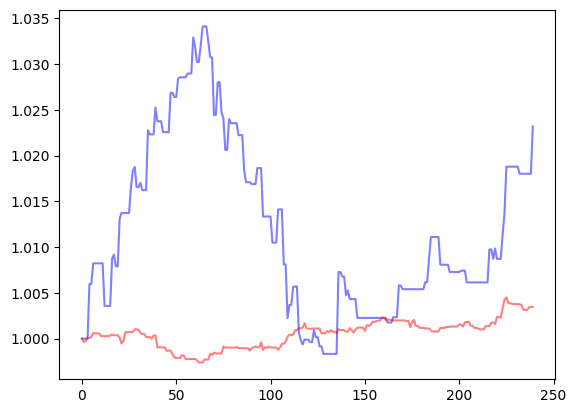

In [13]:
#plot some samples
rand_idxs = np.random.randint(0, len(X_train), 100)
for i in rand_idxs:
    if y_train[i] == 1:
        plt.plot(X_train[i,0,:], c='b', alpha=.5)
        break
    
for i in rand_idxs:
    if y_train[i] == 0:
        plt.plot(X_train[i,0,:], c='r', alpha=.5)
        break

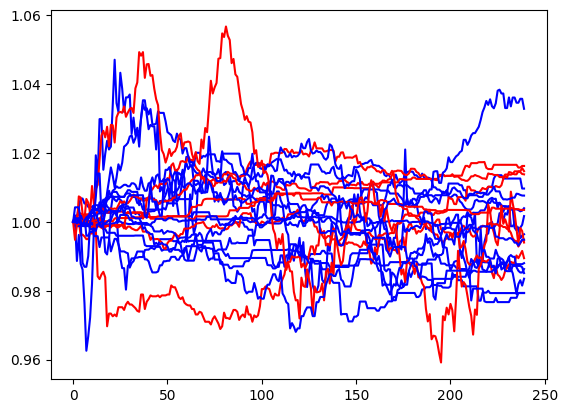

In [14]:
#plot some samples
for i in range(20):
    if y_train[i] == 1:
        plt.plot(X_train[i,0,:], c='b')
    else:
        plt.plot(X_train[i,0,:], c='r')

In [15]:
minirocket = MiniRocket()  # by default, MiniRocket uses ~10_000 kernels
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
# test shape of transformed training data -> (n_instances, 9_996)
X_train_transform.shape


(36104, 9996)

In [16]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

X_train_scaled_transform = scaler.fit_transform(X_train_transform)
classifier.fit(X_train_scaled_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [17]:
X_test_transform = minirocket.transform(X_test)
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, y_test)

0.7030350022153301